# ScanSet workflow and FEDRA emrec applications

Here, the standard reconstruction workflow is illustrated. You may notice they are all bash commands, since we usually perform these operation from the terminal, to build our filesystem

## Creating working folder, getting data

We will use data from SNDCosmics commissionining (first 5 films of WALL1). We will make reconstruction only in 1 cm2 surface, for time and memory reasons.

We create a folder named SNDCosmics_tutorial/b000001 in our filesystem, then we create a link to the data

Plate numbers are named as p001, p002...p005

In [6]:
!mkdir $CERNBOX_HOME/SNDCosmics_tutorial
!mkdir $CERNBOX_HOME/SNDCosmics_tutorial/b000001
!mkdir $CERNBOX_HOME/SNDCosmics_tutorial/b000001/p00{1..5}

we then create a soft link to our raw data in the working folder.

Raw data needs to have name format as 

1.1.0.0.raw.root

The four digits convention is:

* brick number (1, as in b000001);
* plate number (1, as in p001);
* major index (optional);
* minor index (optional);

Major and minor indices are useful to have multiple instances of the set. For now, just set them both to 0

In [11]:
%%bash
for i in $(seq -w 1 5);
do
 ln -s /eos/experiment/sndlhc/emulsionData/SNDCosmics/b000001/p00$i/1.$i.0.0.raw.root $CERNBOX_HOME/SNDCosmics_tutorial/b000001/p00$i/1.$i.0.0.raw.root
done

In [12]:
!ls $CERNBOX_HOME/SNDCosmics_tutorial/b000001

p001  p002  p003  p004	p005


## Fitting base-tracks couples (linking)

Now we connect the information from the two layers of each film. We copy the example of parameters into the working folder

In [1]:
!cp *.rootrc $CERNBOX_HOME/SNDCosmics_tutorial/b000001

Let us have a look at this file

In [2]:
import os
os.chdir(os.environ["CERNBOX_HOME"]+"/SNDCosmics_tutorial/b000001")

In [24]:
!ls
!cat link.rootrc

link.rootrc  p001  p002  p003  p004  p005
fedra.link.AFID:                         1
fedra.link.PixelCorr:                    0 1. 1.
fedra.link.CheckUpDownOffset:            1
fedra.link.BinOK:                        6
fedra.link.NcorrMin:                     100
fedra.link.DoCorrectShrinkage:           1
fedra.link.read.InvertSides:             0
fedra.link.read.HeaderCut:               TMath::Abs(eXview - 96000) < 5000 && TMath::Abs(eYview - 50000) < 5000
fedra.link.read.UseDensityAsW:           0
fedra.link.read.ICUT:                    -1     -500. 500.   -500.   500.    -1.   1.      -1.   1.       0.  50.
fedra.link.RemoveDoublets:               1    5. .1   1
fedra.link.DumpDoubletsTree:             0
fedra.link.shr.NsigmaEQ:                 7.5
fedra.link.shr.Shr0:                     0.9
fedra.link.shr.DShr:                     0.3
fedra.link.shr.ThetaLimits:              0.005  1.
fedra.link.DoCorrectAngles:              1
fedra.link.ang.Chi2max:                  1.5
fedra.l

We can see that only a small area is selected (Header CUT). Let us make a set and proceed to the linking

In [35]:
!makescanset -set=1.0.0.0 -dzbase=175 -from_plate=5 -to_plate=1 -v=2

makescanset     :  for id 000001.0.0.0
EdbScanSet::MakeNominalSet: 000001.0.0.0
ReadScanSet     : from ../b000001/b000001.0.0.0.set.root
ReadScanSet     : from ../b000001/b000001.0.0.0.set.root
ReadScanSet     : from ../b000001/b000001.0.0.0.set.root
ReadPiecePar    : ERROR open file: ../b000001/AFF/1.5.0.0_1.4.0.0.aff.par
ReadAFFtoLayer  : file ../b000001/AFF/1.5.0.0_1.4.0.0.aff.par do not found...
ReadPiecePar    : ERROR open file: ../b000001/AFF/1.4.0.0_1.3.0.0.aff.par
ReadAFFtoLayer  : file ../b000001/AFF/1.4.0.0_1.3.0.0.aff.par do not found...
ReadPiecePar    : ERROR open file: ../b000001/AFF/1.3.0.0_1.2.0.0.aff.par
ReadAFFtoLayer  : file ../b000001/AFF/1.3.0.0_1.2.0.0.aff.par do not found...
ReadPiecePar    : ERROR open file: ../b000001/AFF/1.2.0.0_1.1.0.0.aff.par
ReadAFFtoLayer  : file ../b000001/AFF/1.2.0.0_1.1.0.0.aff.par do not found...
ReadScanSet     : from ../b000001/b000001.0.0.0.set.root
EdbScanSet: 000001.0.0.0
Brick 1 with 5 plates:
  5          0.00        1.000000  0

In [26]:
!emlink -set=1.0.0.0 -new -v=0


----------------------------------------------------------------------------
link set with id= 1.0.0.0
----------------------------------------------------------------------------

OBJ: TCut		TMath::Abs(eXview - 96000) < 5000 && TMath::Abs(eYview - 50000) < 5000
EdbScanProc::LinkRunTest ** AFID=1
ThetaLimits: 0.005000 1.000000
OBJ: TCut		TMath::Abs(eXview - 96000) < 5000 && TMath::Abs(eYview - 50000) < 5000
EdbScanProc::LinkRunTest ** AFID=1
ThetaLimits: 0.005000 1.000000
OBJ: TCut		TMath::Abs(eXview - 96000) < 5000 && TMath::Abs(eYview - 50000) < 5000
EdbScanProc::LinkRunTest ** AFID=1
ThetaLimits: 0.005000 1.000000
OBJ: TCut		TMath::Abs(eXview - 96000) < 5000 && TMath::Abs(eYview - 50000) < 5000
EdbScanProc::LinkRunTest ** AFID=1
ThetaLimits: 0.005000 1.000000
OBJ: TCut		TMath::Abs(eXview - 96000) < 5000 && TMath::Abs(eYview - 50000) < 5000
EdbScanProc::LinkRunTest ** AFID=1
ThetaLimits: 0.005000 1.000000
Info in <TCanvas::Print>: pdf file ../b000001/b000001.0.0.0.link.pdf has been 

In [18]:
import ROOT as r
import fedrarootlogon


Welcome to JupyROOT 6.24/06
Load FEDRA libs


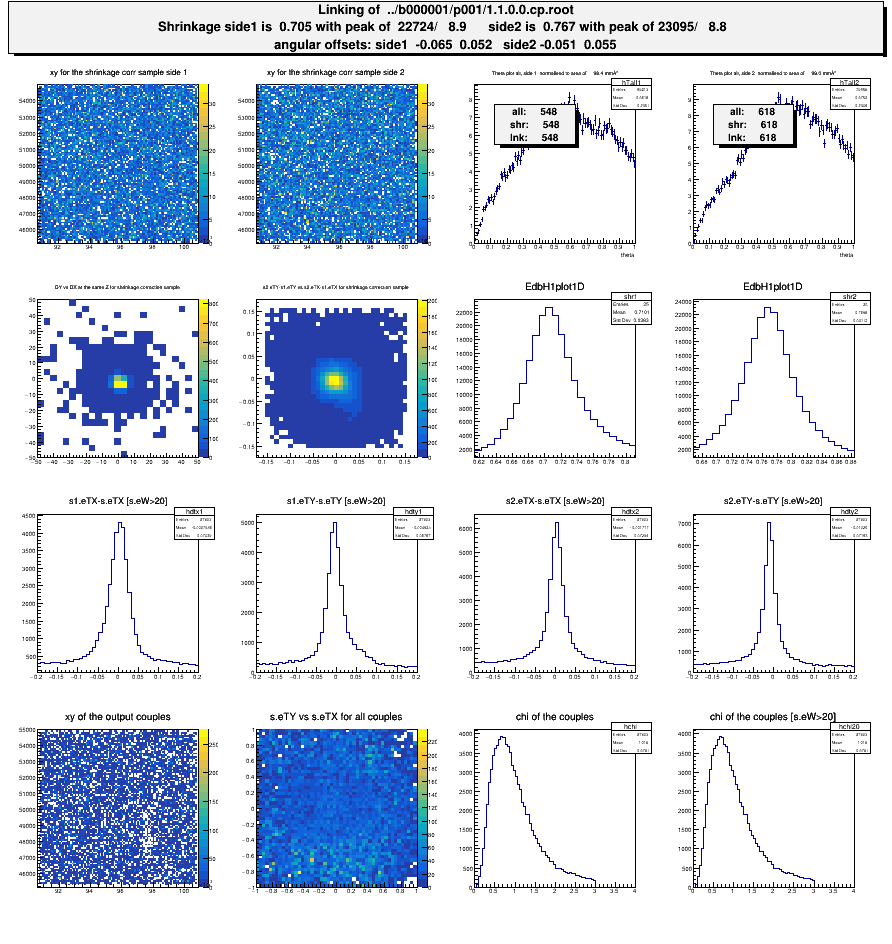

In [32]:
couplesfile = r.TFile.Open("p001/1.1.0.0.cp.root")
reportcanvas = couplesfile.Get("report")
reportcanvas.Draw()

In [3]:
!ls

align.rootrc		b000001.log	    p001  p005
align.save.rootrc	first_align.rootrc  p002  second_align.rootrc
b000001.0.0.0.link.pdf	link.rootrc	    p003  third_align.rootrc
b000001.0.0.0.set.root	link.save.rootrc    p004


## Plate to plate alignment
Finding affine transformation between plates. Parameters are stored in rootrc file

We will perform here a 3 steps alignment, with progressive more restrictive pair of plates

In [4]:
!cat first_align.rootrc

fedra.align.OffsetMax:                   5000
fedra.align.DZ:                          0
fedra.align.DPHI:                        0.05
fedra.align.SigmaR:                      80
fedra.align.SigmaT:                      0.04
fedra.align.DoFine:                      1
fedra.readCPcut:                         eCHI2P<2.0&&s.eW>10&&eN1==1&&eN2==1&&s.Theta()<0.1
fedra.align.SaveCouples:                 1
emalign.outdir:                          ..
emalign.env:                             align.rootrc
emalign.EdbDebugLevel:                   1


In [5]:
%%bash
cp first_align.rootrc align.rootrc
makescanset -set=1.0.0.0 -dzbase=175 -dz=-1350 -from_plate=5 -to_plate=1 -v=2 -reset

makescanset     :  for id 000001.0.0.0
EdbScanSet::MakeNominalSet: 000001.0.0.0
EdbScanProc::CheckDir: create directory ../b000001/AFF
MakeAFFSet      : ../b000001/AFF/1.5.0.0_1.4.0.0.aff.par as ZLAYER 0 -1350.000000 0 0
MakeAFFSet      : ../b000001/AFF/1.5.0.0_1.4.0.0.aff.par as AFFXY 0 1.000000 0.000000 0.000000 1.000000 0.000000 0.000000
MakeAFFSet      : ../b000001/AFF/1.4.0.0_1.3.0.0.aff.par as ZLAYER 0 -1350.000000 0 0
MakeAFFSet      : ../b000001/AFF/1.4.0.0_1.3.0.0.aff.par as AFFXY 0 1.000000 0.000000 0.000000 1.000000 0.000000 0.000000
MakeAFFSet      : ../b000001/AFF/1.3.0.0_1.2.0.0.aff.par as ZLAYER 0 -1350.000000 0 0
MakeAFFSet      : ../b000001/AFF/1.3.0.0_1.2.0.0.aff.par as AFFXY 0 1.000000 0.000000 0.000000 1.000000 0.000000 0.000000
MakeAFFSet      : ../b000001/AFF/1.2.0.0_1.1.0.0.aff.par as ZLAYER 0 -1350.000000 0 0
MakeAFFSet      : ../b000001/AFF/1.2.0.0_1.1.0.0.aff.par as AFFXY 0 1.000000 0.000000 0.000000 1.000000 0.000000 0.000000
ReadScanSet     : from ../b000001

In [7]:
!emalign -set=1.0.0.0 -new -v=0


----------------------------------------------------------------------------
align set 1.0.0.0
----------------------------------------------------------------------------

EdbAffine2D:   1.000000  0.000000  0.000000  1.000000     0.000000     0.000000
EdbAffine2D:   1.000000  0.000000  0.000000  1.000000     0.000000     0.000000
EdbAffine2D:   1.000000  0.000000  0.000000  1.000000     0.000000     0.000000
EdbAffine2D:   1.000000  0.000000  0.000000  1.000000     0.000000     0.000000
Info in <TCanvas::Print>: pdf file ../b000001/b000001.0.0.0.align.pdf has been created using the current canvas
Info in <TCanvas::Print>: Current canvas added to pdf file ../b000001/b000001.0.0.0.align.pdf
Info in <TCanvas::Print>: Current canvas added to pdf file ../b000001/b000001.0.0.0.align.pdf
Info in <TCanvas::Print>: Current canvas added to pdf file ../b000001/b000001.0.0.0.align.pdf and file closed


In [8]:
!cp b000001.0.0.0.align.pdf firstalign_5_1.pdf

In [9]:
!cat second_align.rootrc

fedra.align.OffsetMax:                   1000 
#offsetmax was set to 3000 for plates 51 and 50
fedra.align.DZ:                          100
fedra.align.DPHI:                        0.05
fedra.align.SigmaR:                      30
fedra.align.SigmaT:                      0.03
fedra.align.DoFine:                      1
fedra.readCPcut:                         eCHI2P<2.0&&s.eW>10&&eN1==1&&eN2==1&&s.Theta()>0.1&&s.Theta()<0.5
fedra.align.SaveCouples:                 1
emalign.outdir:                          ..
emalign.env:                             align.rootrc
emalign.EdbDebugLevel:                   1


In [13]:
%%bash
cp second_align.rootrc align.rootrc
makescanset -set=1.0.0.0 -dzbase=175 -dz=-1350 -from_plate=5 -to_plate=1 -v=2

makescanset     :  for id 000001.0.0.0
EdbScanSet::MakeNominalSet: 000001.0.0.0
ReadScanSet     : from ../b000001/b000001.0.0.0.set.root
ReadScanSet     : from ../b000001/b000001.0.0.0.set.root
ReadScanSet     : from ../b000001/b000001.0.0.0.set.root
ReadScanSet     : from ../b000001/b000001.0.0.0.set.root
EdbScanSet: 000001.0.0.0
Brick 1 with 5 plates:
  5          0.00        1.000000  0.000000  0.000000  1.000000        0.000000        0.000000
  4      -1350.00        1.004340  0.019911 -0.003615  1.004391    -1432.391968      357.161102
  3      -2700.00        1.034306  0.027322  0.033702  1.022492    -4728.755859    -3488.176758
  2      -4050.00        1.053373  0.012941  0.031732  1.040722    -5525.438477    -5150.251953
  1      -5400.00        1.073914  0.001003  0.061942  1.042823    -7545.518066    -7629.322266
for this brick 5 identifiers are defined:
000001.5.0.0  shr1/base/shr2 = 1.000 / 175.0 / 1.000
000001.4.0.0  shr1/base/shr2 = 1.000 / 175.0 / 1.000
000001.3.0.0  sh

In [14]:
%%bash
emalign -set=1.0.0.0 -new -v=0
cp b000001.0.0.0.align.pdf secondalign_5_1.pdf


----------------------------------------------------------------------------
align set 1.0.0.0
----------------------------------------------------------------------------

EdbAffine2D:   0.995608 -0.019737  0.003584  0.995557  1433.150146  -350.440948
EdbAffine2D:   0.971239 -0.006479 -0.035534  0.983247  3137.759766  3618.870117
EdbAffine2D:   0.981476  0.014048  0.002399  0.982453   766.679688  1584.959473
EdbAffine2D:   0.980211  0.011467 -0.028017  0.998013  1958.249512  2252.508789


Info in <TCanvas::Print>: pdf file ../b000001/b000001.0.0.0.align.pdf has been created using the current canvas
Info in <TCanvas::Print>: Current canvas added to pdf file ../b000001/b000001.0.0.0.align.pdf
Info in <TCanvas::Print>: Current canvas added to pdf file ../b000001/b000001.0.0.0.align.pdf
Info in <TCanvas::Print>: Current canvas added to pdf file ../b000001/b000001.0.0.0.align.pdf and file closed


In [15]:
!cat third_align.rootrc

fedra.align.OffsetMax:                   100
fedra.align.DZ:                          50
fedra.align.DPHI:                        0.02
fedra.align.SigmaR:                      20
fedra.align.SigmaT:                      0.03
fedra.align.DoFine:                      1
fedra.readCPcut:                         eCHI2P<2.0&&s.eW>10&&eN1==1&&eN2==1
fedra.align.SaveCouples:                 1
emalign.outdir:                          ..
emalign.env:                             align.rootrc
emalign.EdbDebugLevel:                   1


In [16]:
%%bash
cp third_align.rootrc align.rootrc
makescanset -set=1.0.0.0 -dzbase=175 -dz=-1350 -from_plate=5 -to_plate=1 -v=2

makescanset     :  for id 000001.0.0.0
EdbScanSet::MakeNominalSet: 000001.0.0.0
ReadScanSet     : from ../b000001/b000001.0.0.0.set.root
ReadScanSet     : from ../b000001/b000001.0.0.0.set.root
ReadScanSet     : from ../b000001/b000001.0.0.0.set.root
ReadScanSet     : from ../b000001/b000001.0.0.0.set.root
EdbScanSet: 000001.0.0.0
Brick 1 with 5 plates:
  5          0.00        1.000000  0.000000  0.000000  1.000000        0.000000        0.000000
  4      -1351.45        1.000890 -0.001531  0.003118  1.001095      -16.287182     -100.715370
  3      -2663.79        1.006346 -0.005265  0.010515  1.003819     -478.109772     -336.950439
  2      -3989.51        1.007467  0.003946  0.000493  1.003519     -843.867432     -433.531982
  1      -5301.30        1.005064 -0.004666  0.007080  1.003711     -938.619873     -374.983795
for this brick 5 identifiers are defined:
000001.5.0.0  shr1/base/shr2 = 1.000 / 175.0 / 1.000
000001.4.0.0  shr1/base/shr2 = 1.000 / 175.0 / 1.000
000001.3.0.0  sh

In [17]:
%%bash
emalign -set=1.0.0.0 -new -v=0
cp b000001.0.0.0.align.pdf thirdalign_5_1.pdf


----------------------------------------------------------------------------
align set 1.0.0.0
----------------------------------------------------------------------------

EdbAffine2D:   0.999106  0.001528 -0.003112  0.998901    16.426502   100.554008
EdbAffine2D:   0.994540  0.003692 -0.007322  0.997248   460.455994   231.807098
EdbAffine2D:   0.998892 -0.009175  0.009948  1.000260   360.845062   105.088959
EdbAffine2D:   1.002330  0.008591 -0.006552  0.999779   100.160889   -64.781036


Info in <TCanvas::Print>: pdf file ../b000001/b000001.0.0.0.align.pdf has been created using the current canvas
Info in <TCanvas::Print>: Current canvas added to pdf file ../b000001/b000001.0.0.0.align.pdf
Info in <TCanvas::Print>: Current canvas added to pdf file ../b000001/b000001.0.0.0.align.pdf
Info in <TCanvas::Print>: Current canvas added to pdf file ../b000001/b000001.0.0.0.align.pdf and file closed


### Checking alignment reports
They can be found in produced pdfs, or in the al.root files in the AFF folder (**only the latest alignment!**)

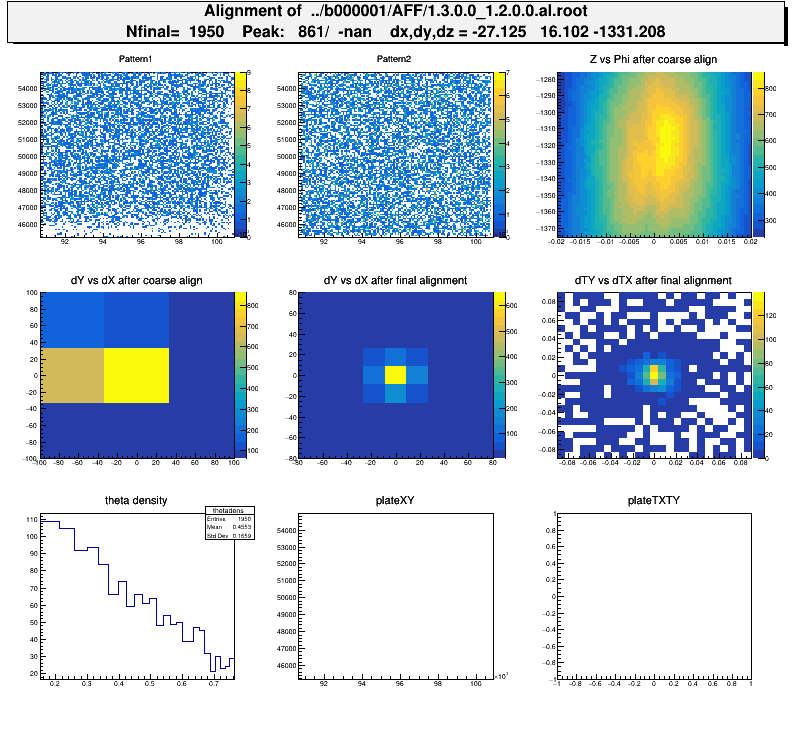

In [19]:
alreportfile = r.TFile.Open("AFF/1.3.0.0_1.2.0.0.al.root")
alreport = alreportfile.Get("report_al")
alreport.Draw()

## Track reconstruction
Finally, we can perform track reconstruction

In [20]:
!makescanset -set=1.0.0.0 -from_plate=5 -to_plate=1 -v=2

makescanset     :  for id 000001.0.0.0
EdbScanSet::MakeNominalSet: 000001.0.0.0
ReadScanSet     : from ../b000001/b000001.0.0.0.set.root
ReadScanSet     : from ../b000001/b000001.0.0.0.set.root
ReadScanSet     : from ../b000001/b000001.0.0.0.set.root
ReadScanSet     : from ../b000001/b000001.0.0.0.set.root
EdbScanSet: 000001.0.0.0
Brick 1 with 5 plates:
  5          0.00        1.000000  0.000000  0.000000  1.000000        0.000000        0.000000
  4      -1360.08        1.001375 -0.002538  0.003421  1.001277      -11.568621     -135.988083
  3      -2682.33        1.001917 -0.008353  0.007344  1.001570      102.259628       83.335159
  2      -4013.54        1.001688  0.001153 -0.002948  1.001117     -122.368973        3.889015
  1      -5317.05        1.000498 -0.007078  0.004847  1.000662     -377.199402      -36.405460
for this brick 5 identifiers are defined:
000001.5.0.0  shr1/base/shr2 = 1.000 / 210.0 / 1.000
000001.4.0.0  shr1/base/shr2 = 1.000 / 210.0 / 1.000
000001.3.0.0  sh

In [21]:
!emtra -set=1.0.0.0 -new -v=0


----------------------------------------------------------------------------
tracking set 1.0.0.0
----------------------------------------------------------------------------

Warning in <TTree::Bronch>: Using split mode on a class: EdbSegP with a custom Streamer
Warning in <TTree::Bronch>: Using split mode on a class: EdbSegP with a custom Streamer


In [23]:
trackfile = r.TFile.Open("b000001.0.0.0.trk.root")
tracktree = trackfile.Get("tracks")
tracktree.GetEntries()

2321